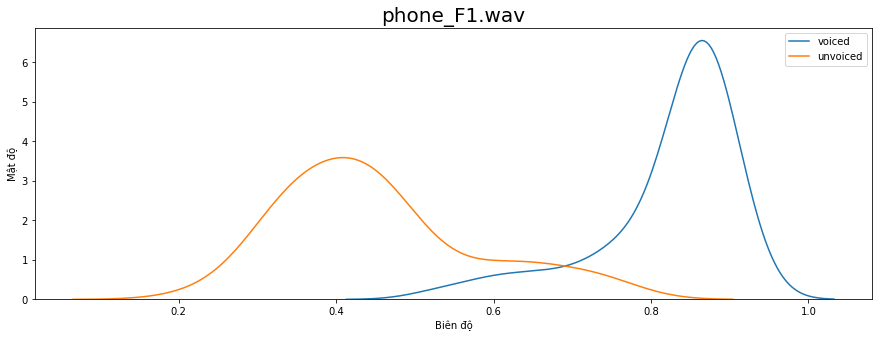

Mean voice:  0.8232266994526258
Mean unvoice:  0.4518916808365096
Std voice:  0.08669678571148845
Std unvoice:  0.12204055547809509
NGƯỠNG:  0.655231075027871


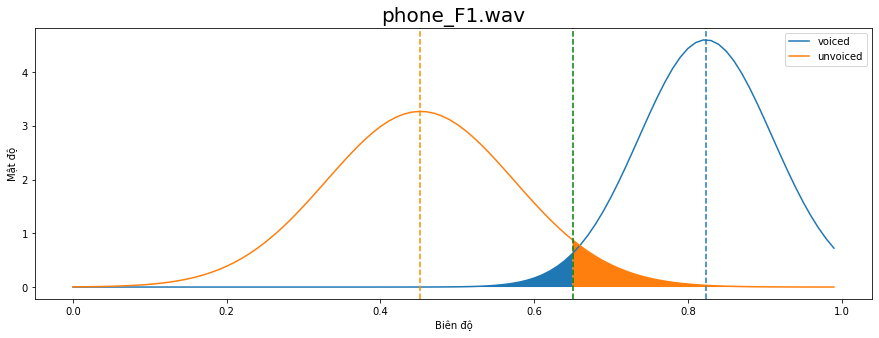

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.io.wavfile import read,write
from IPython.display import Audio
import seaborn as sns
from scipy.signal import find_peaks

# input: mảng 1 chiều chứa giá trị biên độ và tần số của tín hiệu
# output: mảng 2 chiều chứa các khung, mỗi khung chứa các mẫu của tín hiệu

def Split_data(data,Fs):
    N=int (0.025*Fs)    # độ dài khung (đơn vị: mẫu)
    index=[N*i for i in range(int(len(data)/N))]    # tạo mảng các chỉ số đầu của từng khung
    fr_arr=[]    
    for i in range (int(len(data)/N)):
        fr_arr.append(data[index[i]:(index[i]+N)])    # thêm lần lượt từng khung vào mảng
        
    return fr_arr    

#-----------------------------------------------------------------------------------------------------------

# input: mảng 2 chiều chứa các khung, mỗi khung chứa các mẫu của tín hiệu
# output: mảng 2 chiều chứa các khung đã qua xử lý ACF

def Autocorrelation(fr_arr):
    acf_arr=[]    
    N=len(fr_arr[0])
    for i in range (len(fr_arr)):    #duyệt từng khung
        xx=[0]*N    
        for n in range (N):    # tính ACF theo độ trễ n của khung
            xx[n]=sum([fr_arr[i][m]*fr_arr[i][m+n] for m in range (N-n)])    
        acf_arr.append(xx)    # thêm khung đã qua ACF vào mảng 
    return acf_arr

#-----------------------------------------------------------------------------------------------------------

# input: mảng 2 chiều chứa các khung đã qua xử lý ACF
# output: mảng 2 chiều chứa các khung đã qua xử lý ACF và được chuẩn hoá về 0,1

def Normalize(fr_arr):  
    nor_arr=[]    
    for i in range (len(fr_arr)): 
        # tìm min và max của khung
        min_data=min(fr_arr[i])    
        max_data=max(fr_arr[i])    
        
        # chuẩn hoá khung
        nor_fr = []    
        for j in range (len(fr_arr[0])):   
            nor_fr.append((fr_arr[i][j]-min_data)/(max_data-min_data))  
            
        # đưa khung đã chuẩn hoá vào nor_arr
        nor_arr.append(nor_fr)    
    
    return nor_arr

#-----------------------------------------------------------------------------------------------------------

# input: mảng các khung đã qua ACF, tần số của tín hiệu, nhãn từ file lab, tên file wav
# output: in ra đồ thị phân bố của voiced và unvoiced, trả về mảng voiced, unvoiced

def Determine(fr_arr,Fs,x,name):
    Ts=1/Fs
    lim_min=int((1/400)*Fs) 
    lim_max=int((1/70)*Fs)+1
    N=len(fr_arr[0])
    index=[N*i for i in range(len(fr_arr))]    # tạo mảng các chỉ số đầu của từng khung
    v=[]
    uv=[]
    i=0
    for j in range (1,len(x)):
        if (index[i]*Ts<x[j-1]):
            i+=1
        while ((index[i]*Ts)>=x[j-1] and (index[i]*Ts+0.025)<=x[j]):
            fr_arr[i]=np.array(fr_arr[i])
            m=max(fr_arr[i][lim_min:lim_max])
            if (j%2!=0): #unvoiced
                uv.append(m)
            
            else: #voiced
                v.append(m)
        
            i+=1
            if (i==len(index)):
                break
    
    plt.figure(figsize = (15,5))
    plt.title(name,fontsize=20)
    plt.ylabel('Mật độ')
    plt.xlabel('Biên độ')
    sns.kdeplot(v, label='voiced')
    sns.kdeplot(uv,label='unvoiced')
    plt.legend()
    plt.show()
    
    return v, uv

#-----------------------------------------------------------------------------------------------------------

# input: mảng voiced, unvoiced và tên file wav
# output: in ra đồ thị phân bố chuẩn và mean,std của voiced, unvoiced, in ra ngưỡng tìm được của file

def Threshold(v,uv,name)  :
    
    Tv=np.mean(v)-np.std(v)
    Tuv=np.mean(uv)+np.std(uv)
    T=(1/2)*(Tv+Tuv) 
    
    print("Mean voice: ",np.mean(v))
    print("Mean unvoice: ",np.mean(uv))
    print("Std voice: ",np.std(v))
    print("Std unvoice: ",np.std(uv))
    print("NGƯỠNG: ",T)
        
    plt.figure(figsize = (15,5))  
    plt.title(name,fontsize=20)
    plt.ylabel('Mật độ')
    plt.xlabel('Biên độ')
    
    v_nor = np.arange(0, 1, 0.01)
    plt.plot(v_nor, norm.pdf(v_nor, np.mean(v), np.std(v)),label='voiced')
    plt.axvline(x=np.mean(v), linestyle='--')
    plt.fill_between(v_nor,norm.pdf(v_nor, np.mean(v), np.std(v)),0,where=v_nor<=0.65)
    
    
    uv_nor = np.arange(0, 1, 0.01)  
    plt.plot(uv_nor, norm.pdf(uv_nor, np.mean(uv), np.std(uv)),label='unvoiced')
    plt.axvline(x=np.mean(uv),color='darkorange', linestyle='--')
    plt.fill_between(uv_nor,norm.pdf(uv_nor, np.mean(uv), np.std(uv)),0,where=uv_nor>=0.65)
    

      
    plt.axvline(x=0.65,color='green', linestyle='--')
    plt.legend()
    plt.show()
    
    
    return T

#-----------------------------------------------------------------------------------------------------------

def Probability(name,x):
    
    Fs,data=read(name)    #đọc file âm thanh    
    data=data/32768  #đưa biên độ về khoảng -1 , 1
    
    fr_arr=Split_data(data,Fs)    # chia tín hiệu thành các khung
    fr_arr=Autocorrelation(fr_arr)    # tính tự tương quan của các khung
    fr_arr=Normalize(fr_arr)    # chuẩn hoá các khung
    v,uv=Determine(fr_arr,Fs,x,name)    # phân tách voiced/unvoiced 
    return Threshold(v,uv,name)    # trả về giá trị ngưỡng

#-----------------------------------------------------------------------------------------------------------

pF1=[0,0.53,1.14,1.21,1.35,1.45,1.6,1.83,2.2,2.28,2.35,2.4,2.52,2.66,2.73,3.23]    #phone_F1
pM1=[0,0.46,1.39,1.5,1.69,1.79,2.78,2.86,2.93,3.1,3.29,3.45,3.52,4.15]    #phone_M1    
sF1=[0,0.7,1.1,1.13,1.22,1.27,1.65,1.7,1.76,1.79,1.86,1.92,2.15,2.86]    #studio_F1
sM1=[0,0.94,1.26,1.33,1.59,1.66,1.78,1.82,2.06,2.73]    #studio_M1

T_pF1=Probability('phone_F1.wav',pF1)




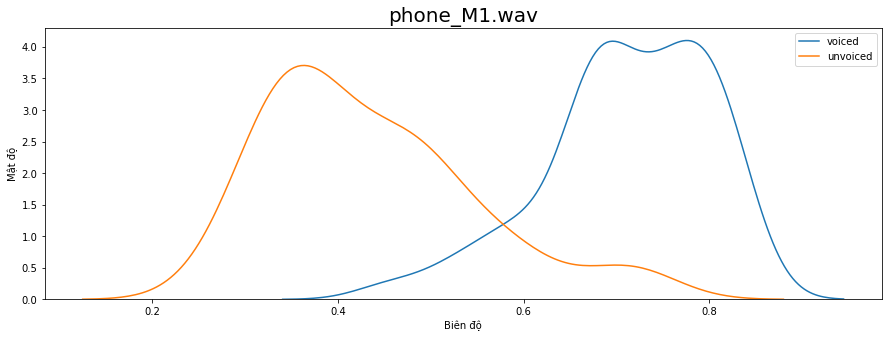

Mean voice:  0.7122037243340557
Mean unvoice:  0.43508437265921185
Std voice:  0.08771612194515292
Std unvoice:  0.11100805453273282
NGƯỠNG:  0.5852900147904238


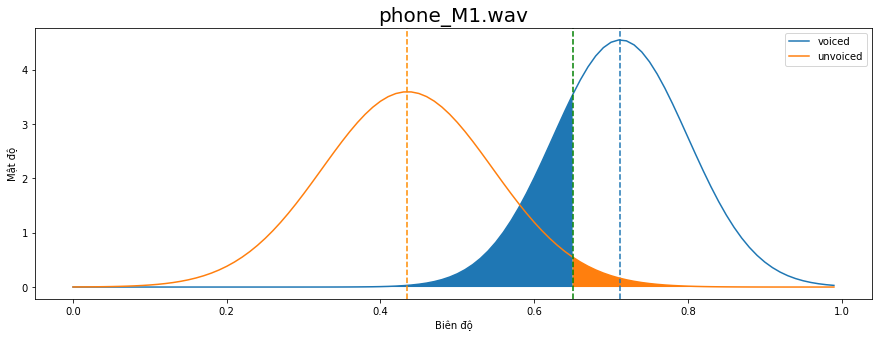

In [2]:

T_pM1=Probability('phone_M1.wav',pM1)


C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_8544/1631696848.py:132: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs,data=read(name)    #đọc file âm thanh


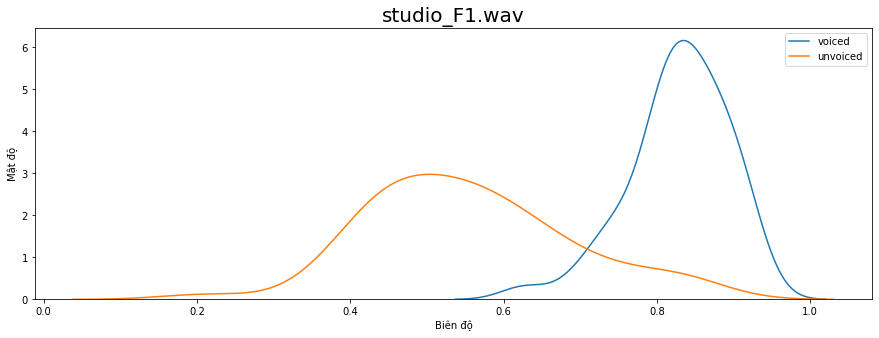

Mean voice:  0.8285235279232811
Mean unvoice:  0.5539043956628208
Std voice:  0.06331276395835121
Std unvoice:  0.12951046279782763
NGƯỠNG:  0.7243128112127892


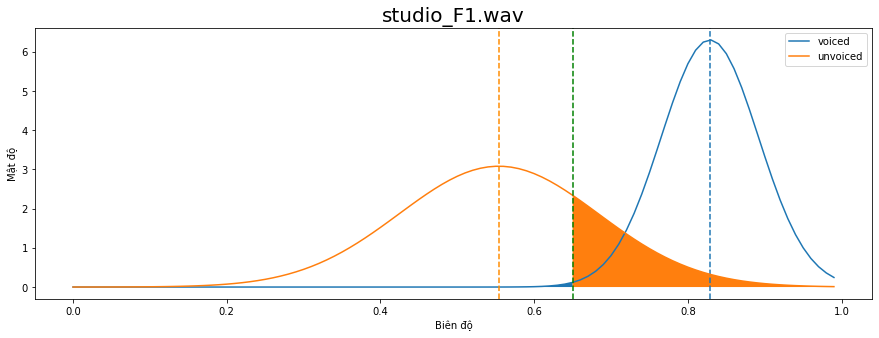

In [3]:

T_sF1=Probability('studio_F1.wav',sF1)


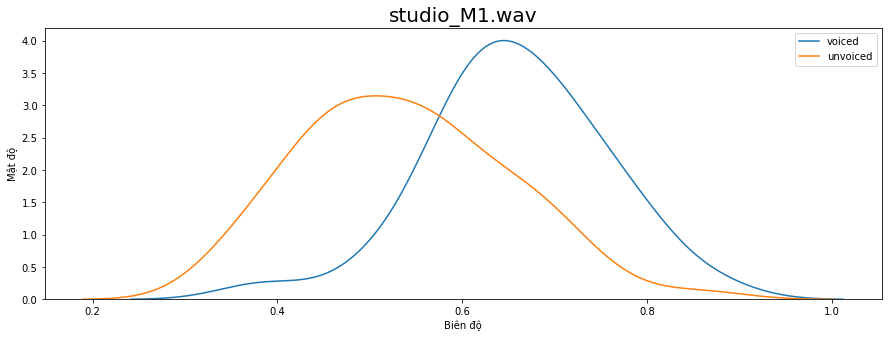

Mean voice:  0.6571476140976972
Mean unvoice:  0.5375699604201039
Std voice:  0.09536996836474618
Std unvoice:  0.11087912497650064
NGƯỠNG:  0.6051133655647778


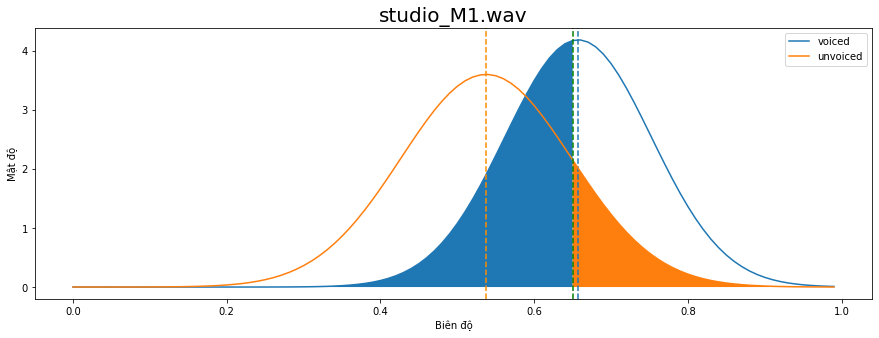

NGƯỠNG TRUNG BÌNH LÀ:  0.6424868166489655


In [4]:

T_sM1=Probability('studio_M1.wav',sM1)

T=(T_pF1+T_pM1+T_sF1+T_sM1)*1/4
print("NGƯỠNG TRUNG BÌNH LÀ: ",T)